In [1]:
!pip install transformers
!pip install tweet-preprocessor

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

from transformers import BertModel
from transformers import BertTokenizer

from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader, \
RandomSampler, SequentialSampler


from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import preprocessor as p
import string

from google.colab import drive

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.EMOJI, p.OPT.HASHTAG)


def remove_characters(str_, chars):
    
    for char in chars:
        str_ = str_.replace(char, '')
        
    return str_


def preprocessing(data):

    data['text'] = data['text'].apply(lambda text: text.lower())
    data['text'] = data['text'].apply(lambda tweet: p.clean(tweet))
    data['text'] = data['text'].apply(lambda tweet: remove_characters(tweet, string.punctuation))

    return data


def generate_x_y(data, max_len=128):

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    x, mask, y = [], [], []
    for i, row in data.iterrows():

        sample = row['text']
        label = row['label']
        tokens = ['[CLS]'] + tokenizer.tokenize(sample) + ['[SEP]']

        if len(tokens) < max_len:
            tokens = tokens + ['[PAD]' for _ in range(max_len - len(tokens))]
        else:
            tokens = tokens[:max_len-1] + ['[SEP]']

        token_ids = tokenizer.convert_tokens_to_ids(tokens)
        sample_mask = [1 if token != '[PAD]' else 0 for token in tokens]

        x.append(token_ids)
        mask.append(sample_mask)
        y.append(label)

    return torch.tensor(x), torch.tensor(mask), torch.tensor(y)


data = pd.read_csv('/content/drive/MyDrive/HateEval/train.csv')
data = preprocessing(data)
x_train, mask_train, y_train = generate_x_y(data)

data = pd.read_csv('/content/drive/MyDrive/HateEval/test.csv')
data = preprocessing(data)
x_test, mask_test, y_test = generate_x_y(data)

In [5]:
class TweetClassifier(nn.Module):

    def __init__(self):

        super(TweetClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        for p in self.bert.parameters():
            p.requires_grad = False

        self.classifier = nn.Sequential(
            nn.Linear(768, 768),
            nn.ReLU(),
            nn.Linear(768, 2),
            nn.Softmax()
        )

    def forward(self, seq, mask):

        outputs = self.bert(input_ids=seq, attention_mask=mask)
        last_hidden_state_cls = outputs[0][:, 0, :]
        out = self.classifier(last_hidden_state_cls)

        return out

In [6]:
train_data = TensorDataset(x_train, mask_train, y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

test_data = TensorDataset(x_test, mask_test, y_test)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=32)

model = TweetClassifier().cuda()

loss = nn.CrossEntropyLoss()
opt = optim.AdamW(model.parameters(), lr=2e-4)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
def train(model, loss_func, opt, train_loader, test_loader, epochs=10):

    model.train()
    train_losses, test_losses = [], []
    for epoch in range(epochs):
        for i, batch in enumerate(train_loader):
            
            model.zero_grad()
            seq, padd_mask, labels = tuple(d.cuda() for d in batch)

            out = model(seq, padd_mask)
            loss = loss_func(out, labels)
            train_losses.append(loss)
            loss.backward()
            opt.step()

            with torch.no_grad():
                
                if (i + 1) % 100 == 0:
                
                    test_loss = 0
                    for b in test_loader:
                        test_seq, test_mask, test_label = tuple(d.cuda() for d in b)
                        pred = model(test_seq, test_mask)
                        test_loss += loss_func(pred, test_label)
                    test_losses.append(test_loss)
                    
                    labels, out = labels.cpu(), out.cpu()
                    out = [np.argmax(pred) for pred in out]
                    acc = accuracy_score(labels, out)
                    print("Iteration {} of epoch {} complete. Loss: {}, Accuracy: {}".format(i+1, epoch+1, loss.item(), acc))

    return model, train_losses, test_losses

In [8]:
model, train_losses, test_losses = train(model, loss, opt, train_dataloader, test_dataloader)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Iteration 100 of epoch 1 complete. Loss: 0.6140472292900085, Accuracy: 0.71875
Iteration 200 of epoch 1 complete. Loss: 0.6183194518089294, Accuracy: 0.6875
Iteration 300 of epoch 1 complete. Loss: 0.6403707265853882, Accuracy: 0.6875
Iteration 100 of epoch 2 complete. Loss: 0.5671705603599548, Accuracy: 0.6875
Iteration 200 of epoch 2 complete. Loss: 0.6136863827705383, Accuracy: 0.65625
Iteration 300 of epoch 2 complete. Loss: 0.6081380844116211, Accuracy: 0.6875
Iteration 100 of epoch 3 complete. Loss: 0.5535573363304138, Accuracy: 0.78125
Iteration 200 of epoch 3 complete. Loss: 0.6355364322662354, Accuracy: 0.65625
Iteration 300 of epoch 3 complete. Loss: 0.6510283946990967, Accuracy: 0.6875
Iteration 100 of epoch 4 complete. Loss: 0.6232389807701111, Accuracy: 0.59375
Iteration 200 of epoch 4 complete. Loss: 0.5858275294303894, Accuracy: 0.75
Iteration 300 of epoch 4 complete. Loss: 0.486839234828949, Accuracy: 0.8125
Iteration 100 of epoch 5 complete. Loss: 0.48093920946121216, 

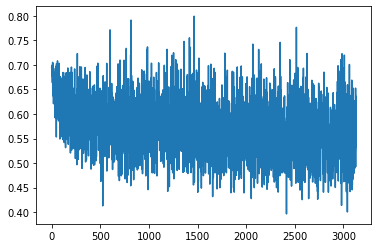

In [11]:
plt.plot(range(len(train_losses)), train_losses)
plt.show()

In [12]:
with torch.no_grad():

    y_true, y_pred = [], []
    for batch in test_dataloader:
        test_seq, test_mask, test_label = tuple(d.cuda() for d in batch)
        pred = model(test_seq, test_mask)
        test_label, pred = test_label.cpu().numpy().tolist(), pred.cpu().numpy().tolist()
        pred = [np.argmax(p) for p in pred]

        y_true = y_true + test_label
        y_pred = y_pred + pred

    print(classification_report(y_true, y_pred))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


              precision    recall  f1-score   support

           0       0.78      0.44      0.56      1740
           1       0.52      0.83      0.64      1260

    accuracy                           0.60      3000
   macro avg       0.65      0.63      0.60      3000
weighted avg       0.67      0.60      0.59      3000



In [13]:
model, train_losses, test_losses = train(model, loss, opt, train_dataloader, test_dataloader, epochs=7)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Iteration 100 of epoch 1 complete. Loss: 0.5207683444023132, Accuracy: 0.8125
Iteration 200 of epoch 1 complete. Loss: 0.6051594614982605, Accuracy: 0.6875
Iteration 300 of epoch 1 complete. Loss: 0.5384622812271118, Accuracy: 0.78125
Iteration 100 of epoch 2 complete. Loss: 0.5237911343574524, Accuracy: 0.75
Iteration 200 of epoch 2 complete. Loss: 0.5545159578323364, Accuracy: 0.71875
Iteration 300 of epoch 2 complete. Loss: 0.5166747570037842, Accuracy: 0.78125
Iteration 100 of epoch 3 complete. Loss: 0.513458788394928, Accuracy: 0.71875
Iteration 200 of epoch 3 complete. Loss: 0.5718437433242798, Accuracy: 0.75
Iteration 300 of epoch 3 complete. Loss: 0.5453049540519714, Accuracy: 0.71875
Iteration 100 of epoch 4 complete. Loss: 0.5912198424339294, Accuracy: 0.6875
Iteration 200 of epoch 4 complete. Loss: 0.5674481987953186, Accuracy: 0.75
Iteration 300 of epoch 4 complete. Loss: 0.675934374332428, Accuracy: 0.625
Iteration 100 of epoch 5 complete. Loss: 0.5745818018913269, Accurac

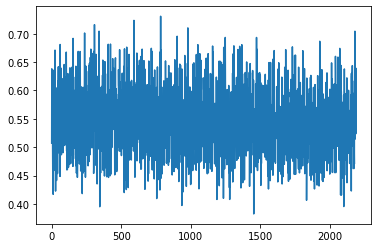

In [14]:
plt.plot(range(len(train_losses)), train_losses)
plt.show()

In [15]:
with torch.no_grad():

    y_true, y_pred = [], []
    for batch in test_dataloader:
        test_seq, test_mask, test_label = tuple(d.cuda() for d in batch)
        pred = model(test_seq, test_mask)
        test_label, pred = test_label.cpu().numpy().tolist(), pred.cpu().numpy().tolist()
        pred = [np.argmax(p) for p in pred]

        y_true = y_true + test_label
        y_pred = y_pred + pred

    print(classification_report(y_true, y_pred))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


              precision    recall  f1-score   support

           0       0.76      0.48      0.59      1740
           1       0.52      0.79      0.63      1260

    accuracy                           0.61      3000
   macro avg       0.64      0.63      0.61      3000
weighted avg       0.66      0.61      0.60      3000



In [16]:
model, train_losses, test_losses = train(model, loss, opt, train_dataloader, test_dataloader, epochs=4)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Iteration 100 of epoch 1 complete. Loss: 0.5456977486610413, Accuracy: 0.78125
Iteration 200 of epoch 1 complete. Loss: 0.6339428424835205, Accuracy: 0.6875
Iteration 300 of epoch 1 complete. Loss: 0.560134768486023, Accuracy: 0.71875
Iteration 100 of epoch 2 complete. Loss: 0.6104092001914978, Accuracy: 0.625
Iteration 200 of epoch 2 complete. Loss: 0.6039937138557434, Accuracy: 0.6875
Iteration 300 of epoch 2 complete. Loss: 0.4750239849090576, Accuracy: 0.84375
Iteration 100 of epoch 3 complete. Loss: 0.5723086595535278, Accuracy: 0.65625
Iteration 200 of epoch 3 complete. Loss: 0.4608580768108368, Accuracy: 0.84375
Iteration 300 of epoch 3 complete. Loss: 0.5506731867790222, Accuracy: 0.75
Iteration 100 of epoch 4 complete. Loss: 0.4933106005191803, Accuracy: 0.78125
Iteration 200 of epoch 4 complete. Loss: 0.467776358127594, Accuracy: 0.875
Iteration 300 of epoch 4 complete. Loss: 0.48181647062301636, Accuracy: 0.84375


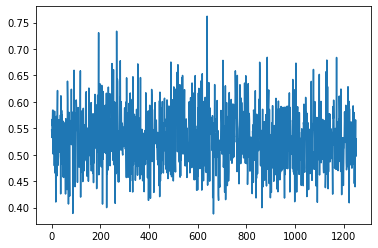

In [17]:
plt.plot(range(len(train_losses)), train_losses)
plt.show()

In [18]:
with torch.no_grad():

    y_true, y_pred = [], []
    for batch in test_dataloader:
        test_seq, test_mask, test_label = tuple(d.cuda() for d in batch)
        pred = model(test_seq, test_mask)
        test_label, pred = test_label.cpu().numpy().tolist(), pred.cpu().numpy().tolist()
        pred = [np.argmax(p) for p in pred]

        y_true = y_true + test_label
        y_pred = y_pred + pred

    print(classification_report(y_true, y_pred))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


              precision    recall  f1-score   support

           0       0.77      0.44      0.56      1740
           1       0.51      0.82      0.63      1260

    accuracy                           0.60      3000
   macro avg       0.64      0.63      0.60      3000
weighted avg       0.66      0.60      0.59      3000

